In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

Shape of X_train_lstm: (1935, 30, 1)
Shape of y_train_lstm: (1935, 1)
Epoch 1/50
49/49 [==============================] - 18s 101ms/step - loss: 7.6291e-04 - val_loss: 0.0142
Epoch 2/50
49/49 [==============================] - 2s 50ms/step - loss: 1.5825e-04 - val_loss: 0.0050
Epoch 3/50
49/49 [==============================] - 3s 56ms/step - loss: 1.2948e-04 - val_loss: 0.0076
Epoch 4/50
49/49 [==============================] - 3s 62ms/step - loss: 1.2648e-04 - val_loss: 0.0040
Epoch 5/50
49/49 [==============================] - 3s 55ms/step - loss: 1.0240e-04 - val_loss: 0.0038
Epoch 6/50
49/49 [==============================] - 3s 55ms/step - loss: 1.0071e-04 - val_loss: 0.0026
Epoch 7/50
49/49 [==============================] - 2s 47ms/step - loss: 9.2564e-05 - val_loss: 0.0026
Epoch 8/50
49/49 [==============================] - 2s 48ms/step - loss: 8.0565e-05 - val_loss: 0.0024
Epoch 9/50
49/49 [==============================] - 2s 49ms/step - loss: 7.8700e-05 - val_loss: 0.0023
E

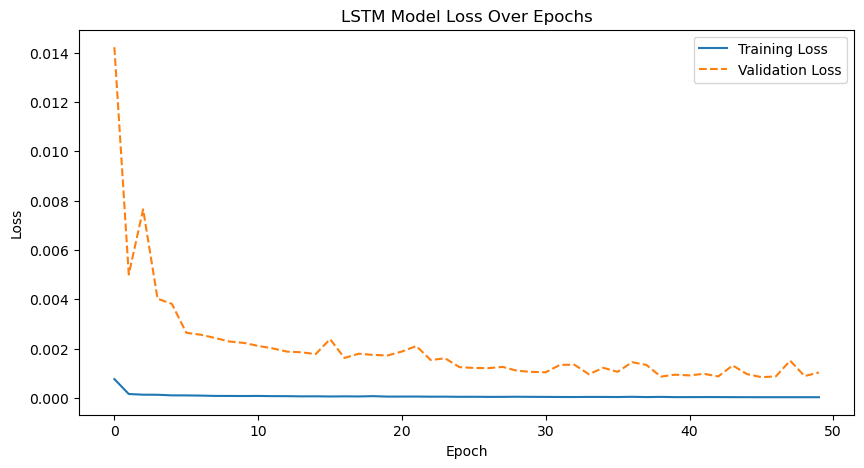

16/16 [==============================] - 0s 17ms/step
LSTM RMSE: 1683.81079537394
LSTM R²: 0.9891879020661543
LSTM MAE: 1026.3863737248191


NameError: name 'train_index' is not defined

<Figure size 1400x700 with 0 Axes>

In [4]:
# Load dataset 
data = pd.read_csv('merged_data.csv', parse_dates=['Date'], index_col='Date')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

look_back = 30

# Prepare the sequences of input data
X_lstm, y_lstm = [], []
for i in range(look_back, len(scaled_data)):
    X_lstm.append(scaled_data[i-look_back:i, 0])
    y_lstm.append(scaled_data[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

y_train_lstm = y_train_lstm.reshape(-1, 1)
y_test_lstm = y_test_lstm.reshape(-1, 1)

# Check shapes
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of y_train_lstm:", y_train_lstm.shape)

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and store the training history
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
train_predict_lstm = model_lstm.predict(X_train_lstm)
test_predict_lstm = model_lstm.predict(X_test_lstm)

# Invert the scaling for RMSE calculation
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
y_train_lstm = scaler.inverse_transform(y_train_lstm)
y_test_lstm = scaler.inverse_transform(y_test_lstm)

# Calculate RMSE, R², and MAE for the LSTM model
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, test_predict_lstm))
lstm_r2 = r2_score(y_test_lstm, test_predict_lstm)
mae = mean_absolute_error(y_test_lstm, test_predict_lstm)

# Print RMSE, R², and MAE
print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R²: {lstm_r2}")
print(f"LSTM MAE: {mae}")

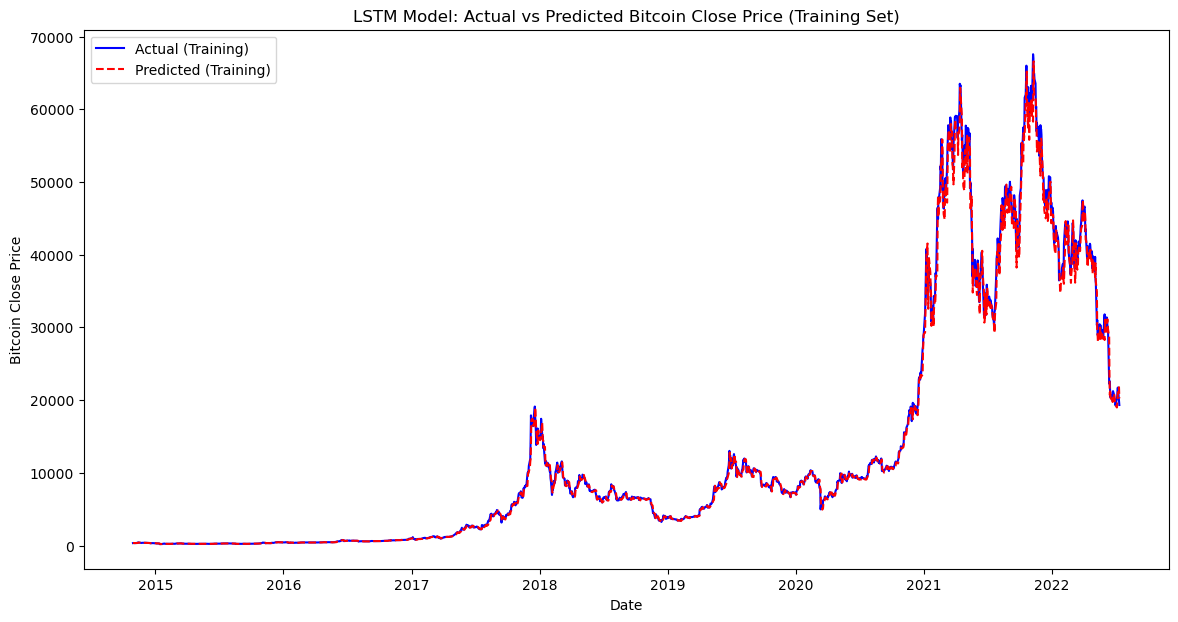

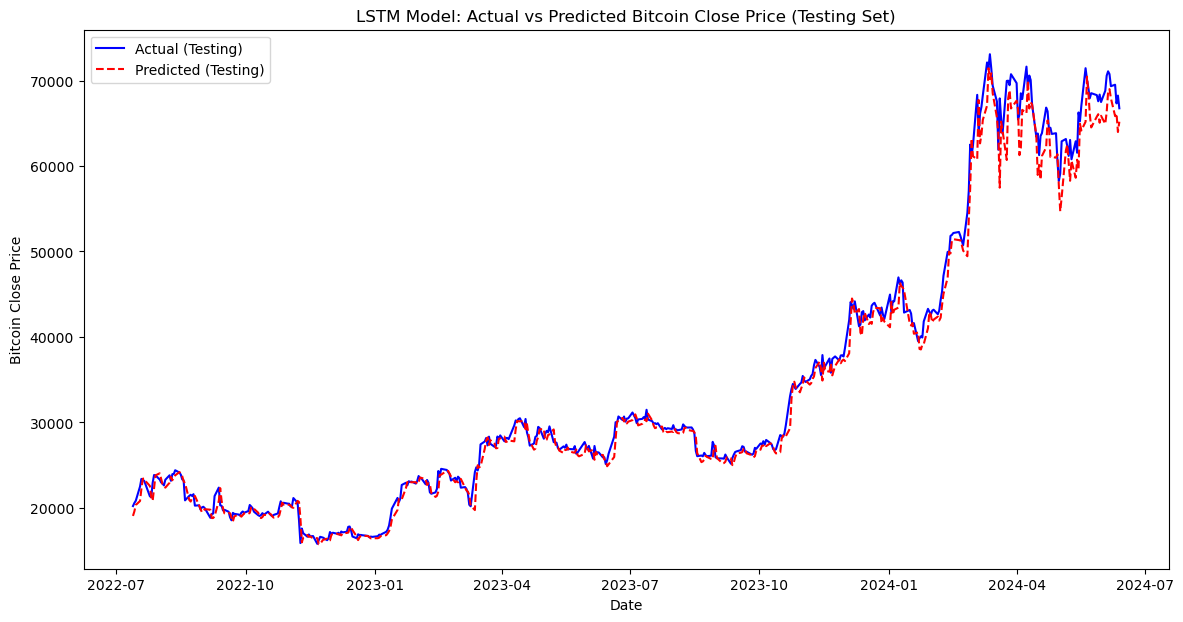

In [12]:
# Calculate the correct length for y_train_lstm and train_predict_lstm
train_index = data.index[look_back:train_size + look_back]
test_index = data.index[train_size + look_back:]


# Plotting the forecasted vs actual values for the training set
plt.figure(figsize=(14, 7))
plt.plot(train_index, y_train_lstm, label='Actual (Training)', color='blue')
plt.plot(train_index, train_predict_lstm, label='Predicted (Training)', color='red', linestyle='--')
plt.title('LSTM Model: Actual vs Predicted Bitcoin Close Price (Training Set)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close Price')
plt.legend()
plt.show()

# Plotting the forecasted vs actual values for the testing set
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test_lstm, label='Actual (Testing)', color='blue')
plt.plot(test_index, test_predict_lstm, label='Predicted (Testing)', color='red', linestyle='--')
plt.title('LSTM Model: Actual vs Predicted Bitcoin Close Price (Testing Set)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Close Price')
plt.legend()
plt.show()

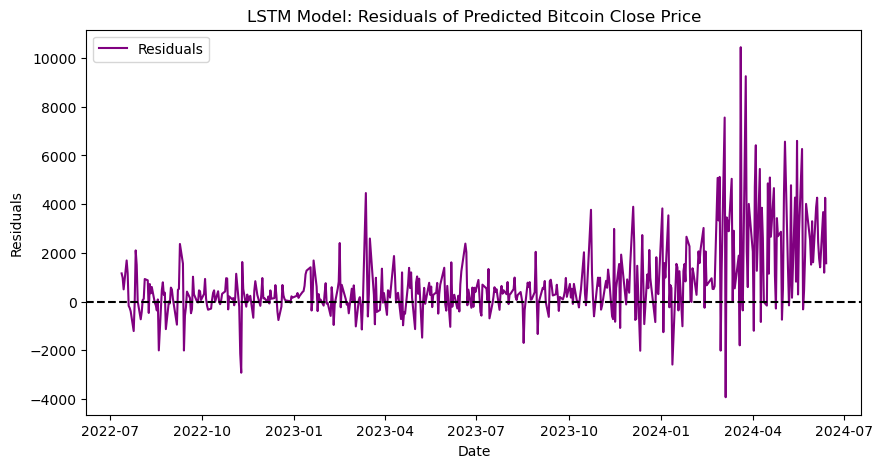

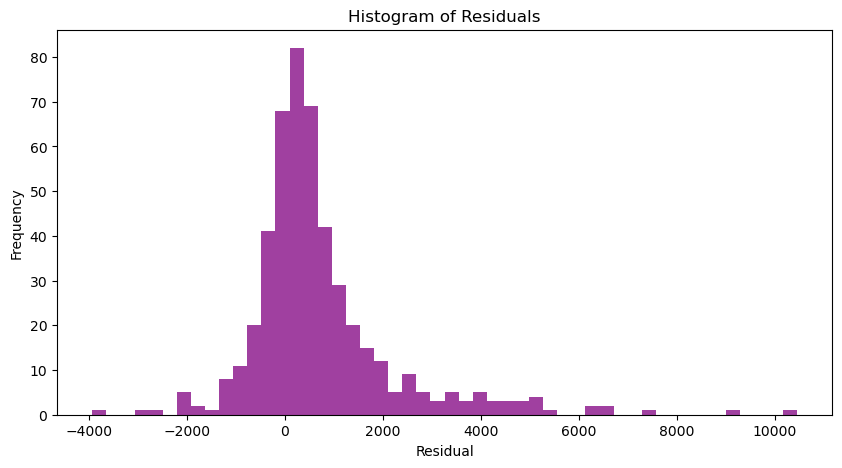

In [8]:
# Calculate residuals
test_residuals = y_test_lstm - test_predict_lstm

# Plotting the residuals for the testing set
plt.figure(figsize=(10, 5))
plt.plot(data.index[train_size + look_back:], test_residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('LSTM Model: Residuals of Predicted Bitcoin Close Price')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(test_residuals, bins=50, color='purple', alpha=0.75)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [10]:
print (model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
